In [42]:
using JuMP
using Clp, HiGHS, Ipopt, Juniper
using Plots
using LinearAlgebra
using NamedArrays
using Graphs, GraphPlot, SimpleWeightedGraphs

Plots.gr();

In [1]:
# Basic terrain cost field for initial pathing tests

basicTerrain(x, y) = exp(-1(x^2 + y^2))

# Interpret as going from -boundary to boundary in resolution steps
boundary = 1
resolution = 3

# Generate discrete field
discreteField = zeros(boundary * resolution * 2 + 1, boundary * resolution * 2 + 1)

for i in 1:resolution*boundary*2+1
  for j in 1:resolution*boundary*2+1
    
    # Rearange axis
    x = (i - resolution * boundary - 1) / resolution
    y = (j - resolution * boundary - 1) / resolution
    discreteField[i,j] = round(basicTerrain(x,y), digits=3)
  
  end
end

# Show graph
show(stdout, "text/plain", discreteField)

f(x, y) = sin(x) + cos(y)
#surface(-boundary:0.1/resolution:boundary, -boundary:0.1/resolution:boundary, basicTerrain)

7×7 Matrix{Float64}:
 0.135  0.236  0.329  0.368  0.329  0.236  0.135
 0.236  0.411  0.574  0.641  0.574  0.411  0.236
 0.329  0.574  0.801  0.895  0.801  0.574  0.329
 0.368  0.641  0.895  1.0    0.895  0.641  0.368
 0.329  0.574  0.801  0.895  0.801  0.574  0.329
 0.236  0.411  0.574  0.641  0.574  0.411  0.236
 0.135  0.236  0.329  0.368  0.329  0.236  0.135

f (generic function with 1 method)

In [44]:
# Text discrete field matrix
#discreteField = [1 4 7; 
#                 2 5 8; 
#                 3 6 9]

# Conection matrix from discrete field
connectionMatrix = fill(Inf, (length(discreteField), length(discreteField)))

# Dimensions from discrete field are usefull
verticalSize = size(discreteField, 1)
horizontalSize = size(discreteField, 2)

#println("verticalSize ", verticalSize)
#println("horizontalSize ", horizontalSize)

# Complete conection matrix
# Algorithm has complexity O(n²)
for j in axes(discreteField, 2)
  for i in axes(discreteField, 1)
    # Matrix is iterated from top to bottom
    # then from left to right
    loc = (j - 1) * verticalSize + i
    #println((i,j)," ", loc)

    # Not at left boundary
    if loc > verticalSize
      #println("Left connection at ", (i,j), " to ", (i,j - 1))
      connectionMatrix[loc,loc - horizontalSize] = abs(discreteField[i,j] - discreteField[i,j - 1])
    end

    # Not at right boundary
    if loc ≤ verticalSize * (horizontalSize - 1)
      #println("Right connection at ", (i,j), " to ", (i,j + 1))
      connectionMatrix[loc,loc + horizontalSize] = abs(discreteField[i,j] - discreteField[i,j + 1])
    end
    
    # Not at bottom boundary
    if loc % verticalSize != 0
      #println("Lower connection at ", (i,j), " to ", (i + 1,j))
      connectionMatrix[loc,loc + 1] = abs(discreteField[i,j] - discreteField[i + 1,j])
    end

    # Not at top boundary
    if loc % verticalSize != 1
      #println("Upper connection at ", (i,j), " to ", (i - 1,j))
      connectionMatrix[loc,loc - 1] = abs(discreteField[i,j] - discreteField[i - 1,j])
    end
  end
end

#connectionMatrix[connectionMatrix.==Inf] .= 0

# Visually clear matrix
namedArray = NamedArray(connectionMatrix)
setdimnames!(namedArray, ("Origin", "Destiny"));
namedArray

121×121 Named Matrix{Float64}
Origin ╲ Destiny │     1      2      3      4  …    118    119    120    121
─────────────────┼──────────────────────────────────────────────────────────
1                │   Inf  0.059    Inf    Inf  …    Inf    Inf    Inf    Inf
2                │ 0.059    Inf  0.063    Inf       Inf    Inf    Inf    Inf
3                │   Inf  0.063    Inf  0.056       Inf    Inf    Inf    Inf
4                │   Inf    Inf  0.056    Inf       Inf    Inf    Inf    Inf
5                │   Inf    Inf    Inf   0.04       Inf    Inf    Inf    Inf
6                │   Inf    Inf    Inf    Inf       Inf    Inf    Inf    Inf
7                │   Inf    Inf    Inf    Inf       Inf    Inf    Inf    Inf
8                │   Inf    Inf    Inf    Inf       Inf    Inf    Inf    Inf
⋮                      ⋮      ⋮      ⋮      ⋮  ⋱      ⋮      ⋮      ⋮      ⋮
114              │   Inf    Inf    Inf    Inf       Inf    Inf    Inf    Inf
115              │   Inf    Inf    Inf    Inf 

In [45]:
connectionMatrix[connectionMatrix.==Inf] .= 0

#connectionMatrix = [0 2 1 0 0;
#                    2 0 0 0 1;
#                    1 0 0 1 0;
#                    0 0 1 0 1;
#                    0 1 0 1 0
#                    ]

#connectionMatrix = [0 1 2 0 0;
#                    1 0 0 0 3;
#                    2 0 0 1 0;
#                    0 0 1 0 1;
#                    0 3 0 1 0
#                    ]

n = size(connectionMatrix, 1)
b = zeros(1,n)
start = 1
b[start] = 1
b[n ÷ 2 + 1] = -1

nl_solver = optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)
mip_solver = optimizer_with_attributes(HiGHS.Optimizer, "output_flag"=>false)
minlp_solver = optimizer_with_attributes(Juniper.Optimizer, "nl_solver"=>nl_solver, "mip_solver"=>mip_solver)


m = Model(minlp_solver)
set_silent(m)

# Choice binary matrix
@variable(m, x[1:n, 1:n], Bin)

# Paths with cost zero should be ignored
@constraint(m, [i = 1:n, j = 1:n; connectionMatrix[i, j] == 0], x[i, j] == 0)

# Flow conservation constraint
@constraint(m, [i = 1:n], sum(x[i, :]) - sum(x[:, i]) == b[i],)

@objective(m, Min, sum(connectionMatrix .* x))
optimize!(m)
println("Cost ", objective_value(m))

#show(IOContext(stdout, :limit => false, :displaysize => (30,30)), MIME"text/plain"(), connectionMatrix .* value.(x))


Cost 0.865


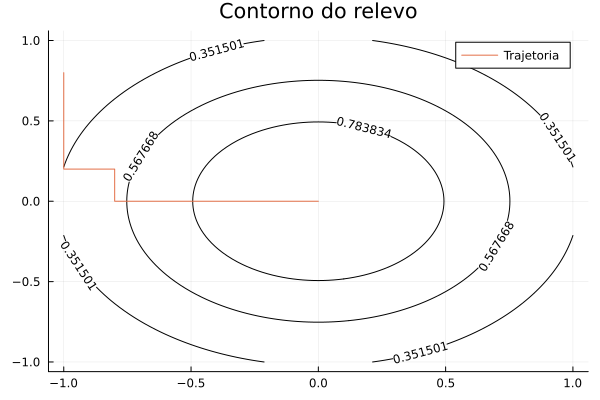

In [46]:
indexes = findall(x->x==1, value.(x))
points = []
for index in indexes
  point = (-(boundary - (index[2] - 1) % verticalSize / resolution),(boundary - (index[2]) ÷ verticalSize / resolution))
  push!(points, point)
end

contour(-boundary:0.1/resolution:boundary, -boundary:0.1/resolution:boundary, basicTerrain, color=:black, clabels=true, levels=3, cbar=false, title="Contorno do relevo")
plot!([point[1] for point in points], [point[2] for point in points], label="Trajetoria")